In [1]:
import sys, os

sys.path.append(os.path.abspath(
    os.getcwd()+"/src")
)

In [4]:
from src.data_management import deformation_from_name
from src.data_gen import deformation_to_image_mapper
from src.benchmark import benchmark_nn_decoder

from qecsim.models.rotatedplanar import RotatedPlanarCode
from qecsim.models.generic import BiasedDepolarizingErrorModel

import json
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import random

key = random.key(0)

In [ ]:
model_dir = "../results"
model_names = os.listdir(model_dir)
batch_size = 10_000_000
error_probabilities = jnp.array(BiasedDepolarizingErrorModel(
    bias=500,
    axis="Z"
).probability_distribution(0.1))
OVERWRITE_EXISTING = False

for model_name in model_names:
    ler, hist2d = benchmark_nn_decoder(
        random.key(0), # Use the same key for all models for better comparability
        batch_size, 
        model_name, 
        error_probabilities=error_probabilities, 
        with_histogram_2d=True
    )
    result = {
        "hist2d": hist2d.tolist(),
        "error_probabilities": error_probabilities.tolist(),
        "batch_size": batch_size,
        "ler": float(ler)
    }
    if os.path.exists(f"{model_dir}/{model_name}/benchmark.json") and not OVERWRITE_EXISTING:
        answer = ""
        while answer.lower() not in ("y", "n"):
            answer = input(f"A benchmark result for model {model_name} already exists. Overwrite? (y/n) ")
        if answer.lower() == "n":
            print(f"Skipping model {model_name}")
            continue
    with open(f"{model_dir}/{model_name}/benchmark.json", "w") as f:
        json.dump(result, f, indent=4)
    print(f"Model: {model_name}, LER: {ler:.5%}")

Model: C1_d3_100K, LER: 3.21000%


Logical error rate is 3.21% under a physical error rate of 10.00%


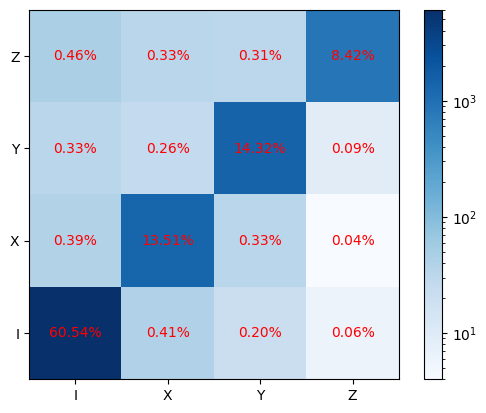

In [5]:
model_name = "C1_d3_100K"

with open(f"{model_dir}/{model_name}/benchmark.json", "r") as f:
    result = json.load(f)

hist2d = jnp.array(result["hist2d"])
error_probabilities = jnp.array(result["error_probabilities"])
batch_size = result["batch_size"]
ler = result["ler"]

print(f"Logical error rate is {ler:.2%} under a physical error rate of {error_probabilities[1:].sum():.2%}")

plt.figure()
plt.imshow(hist2d, cmap='Blues', interpolation='nearest', norm='log')
for i in range(4):
    for j in range(4):
        plt.text(j, i, f"{hist2d[i, j] / batch_size :.2%}", ha='center', va='center', color='red')
plt.colorbar()
plt.gca().invert_yaxis()
plt.yticks(range(4), ['I', 'X', 'Y', 'Z'])
plt.xticks(range(4), ['I', 'X', 'Y', 'Z'])
plt.show()